In [1]:
import requests as rq
import pandas as pd
import sqlite3 as sql
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_712/996562174.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#API call function
def api_call(output_size, api_key):
    return rq.get(f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AMZN&outputsize={output_size}&apikey={api_key}').json()

In [3]:
#Establish SQLite connection
conn = sql.connect("stocks.db")
cursor = conn.cursor()

stmnt1 = '''create table if not exists amzn (
    date date primary key,
    open float,
    high float,
    low float,
    close float,
    volume int
    )
'''
cursor.execute(stmnt1)

In [4]:
#API request parameter depends on table's state
is_empty = True
if conn.execute(f"SELECT COUNT(*) FROM amzn;").fetchone()[0] == 0:
    data = api_call('full', 'KVUJT3KI90X21VGB')
else:
    data = api_call('compact', 'KVUJT3KI90X21VGB')
    is_empty = False

time_series_data = data["Time Series (Daily)"]

In [41]:
#Clean and format data
df = pd.DataFrame(time_series_data).T

for col in ["1. open", "2. high", "3. low", "4. close"]:
    df[col] = df[col].astype(float)
df["5. volume"] = df["5. volume"].astype(int)

df.rename(columns={'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. volume': 'volume'}, inplace=True)
df = df.reset_index().rename(columns={'index': 'date'})

df

,date,open,high,low,close,volume
0,2024-02-20,167.83,168.7100,165.7400,167.08,41980326
1,2024-02-16,168.74,170.4200,167.1700,169.51,48107744
2,2024-02-15,170.58,171.1700,167.5900,169.80,49855196
3,2024-02-14,169.21,171.2100,168.2800,170.98,42815544
4,2024-02-13,167.73,170.9500,165.7500,168.64,56345122
...,...,...,...,...,...,...
95,2023-10-03,128.06,128.5200,124.2544,124.72,51564991
96,2023-10-02,127.28,130.4700,126.5400,129.46,48029744
97,2023-09-29,128.20,129.1500,126.3200,127.12,62411730
98,2023-09-28,124.04,126.5801,123.0400,125.98,54554968


In [20]:
#Insert data depending on state of table
if is_empty:
    df.to_sql('amzn', conn, index=False, if_exists='append')
    print("All data inserted.")
else:
    max_date = conn.execute("SELECT MAX(date) FROM amzn;").fetchone()[0]
    df_filtered = df[pd.to_datetime(df['date']) > pd.to_datetime(max_date)]
    if df_filtered.empty: 
        print("No new data to insert.")
    else:
        df_filtered.to_sql('amzn', conn, index=False, if_exists='append')
        conn.commit()
        print("New data inserted.") 

No new data to insert.


In [37]:
#Pull all data from database into dataframe for analysis, sort by most recent date and adjust numbers for pre-split stock
query = 'select * from amzn'
df2 = pd.read_sql_query(query, conn).sort_values('date', ascending=False)
df2['date'] = pd.to_datetime(df2['date'])
df2.set_index('date', inplace=True)

condition = df2.index < pd.to_datetime('2022-06-06')
df2.loc[condition, ['open', 'high', 'low', 'close']] /= 20
df2

,open,high,low,close,volume
date,,,,,
2024-02-20,167.8300,168.7100,165.7400,167.0800,41980326
2024-02-16,168.7400,170.4200,167.1700,169.5100,48107744
2024-02-15,170.5800,171.1700,167.5900,169.8000,49855196
2024-02-14,169.2100,171.2100,168.2800,170.9800,42815544
2024-02-13,167.7300,170.9500,165.7500,168.6400,56345122
...,...,...,...,...,...
1999-11-05,3.2375,3.2750,3.1125,3.2470,11091400
1999-11-04,3.3595,3.3595,3.0500,3.1530,16759200
1999-11-03,3.4095,3.4250,3.2500,3.2905,10772100


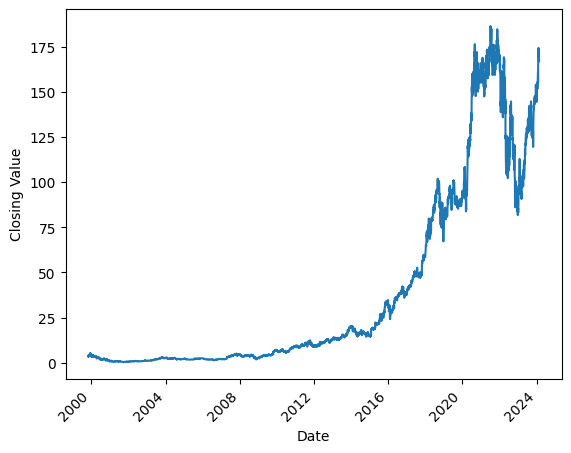

In [38]:
sns.lineplot(x=df2.index, y='close', data=df2)
plt.xlabel('Date')
plt.ylabel('Closing Value')
plt.xticks(rotation=45, ha='right')
plt.show()

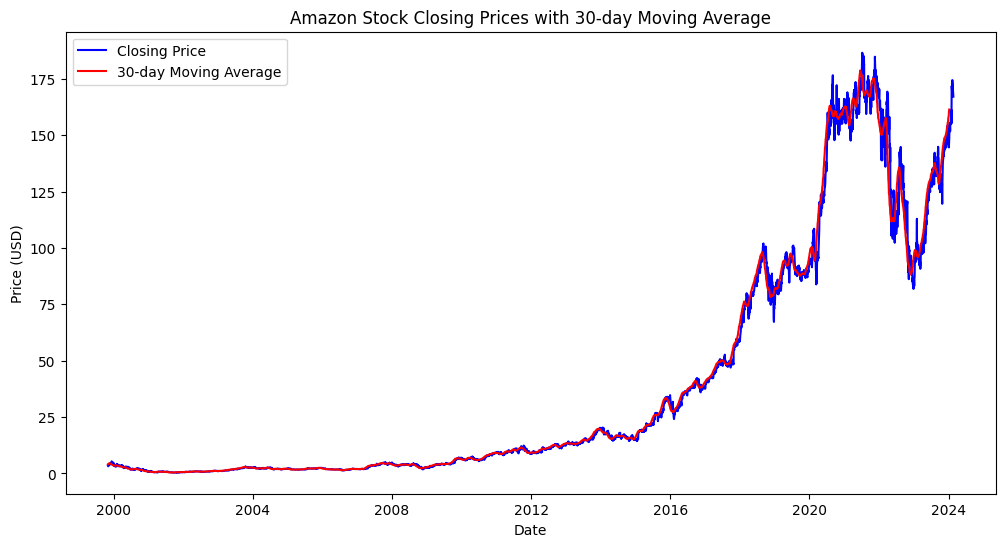

In [23]:
df2['30_MA'] = df2['close'].rolling(window=30).mean()
# Plotting Closing Prices and 30-day Moving Average
plt.figure(figsize=(12, 6))
plt.plot(df2.index, df2['close'], label='Closing Price', color='blue')
plt.plot(df2.index, df2['30_MA'], label='30-day Moving Average', color='red')
plt.title('Amazon Stock Closing Prices with 30-day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

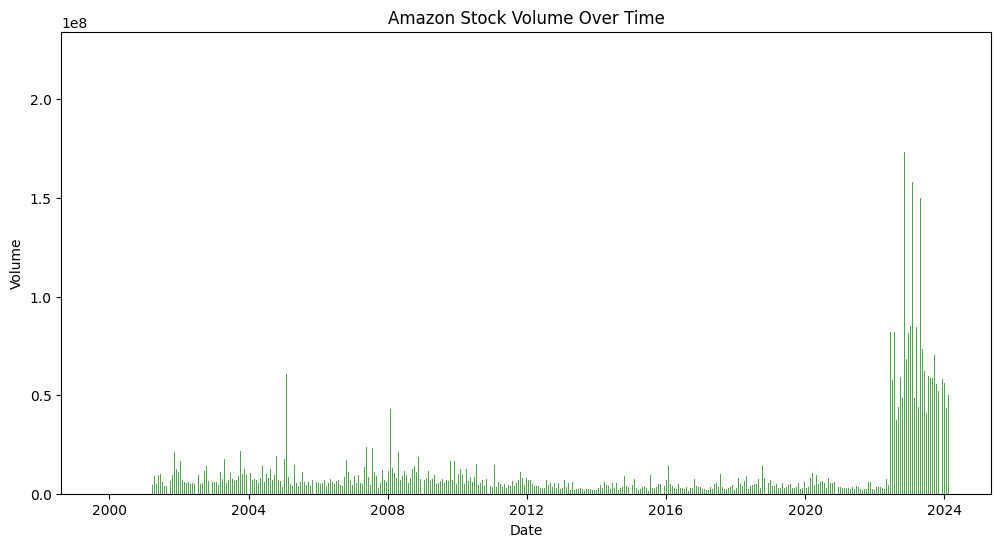

In [52]:
plt.figure(figsize=(12, 6))
plt.bar(df2.index, df2['volume'], color='green', alpha=0.7)
plt.title('Amazon Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

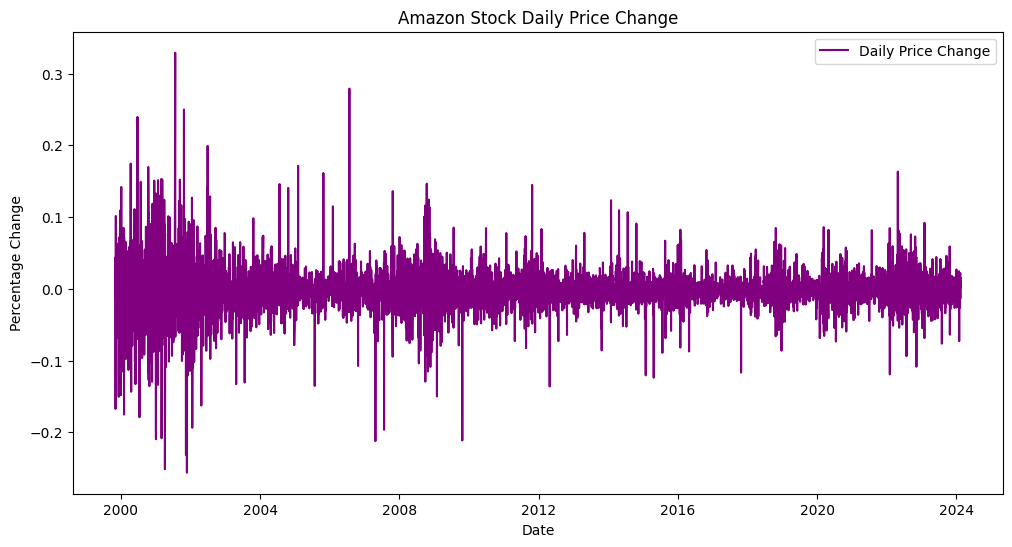

In [53]:
# Calculate daily price change
df2['daily_change'] = df2['close'].pct_change()
# Plotting Daily Price Change
plt.figure(figsize=(12, 6))
plt.plot(df2.index, df2['daily_change'], label='Daily Price Change', color='purple')
plt.title('Amazon Stock Daily Price Change')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend()
plt.show()

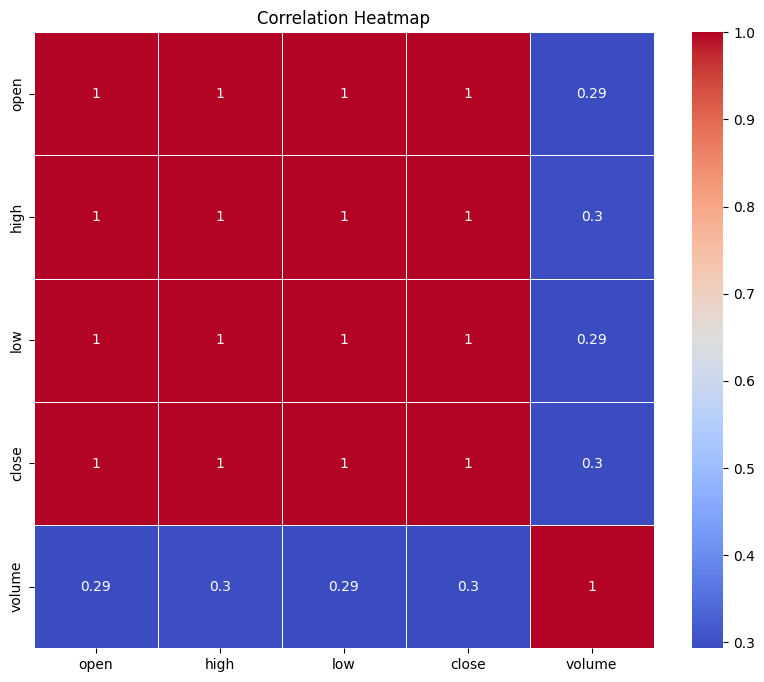

In [54]:
# Calculate correlation matrix
correlation_matrix = df2[['open', 'high', 'low', 'close', 'volume']].corr()
# Plotting Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

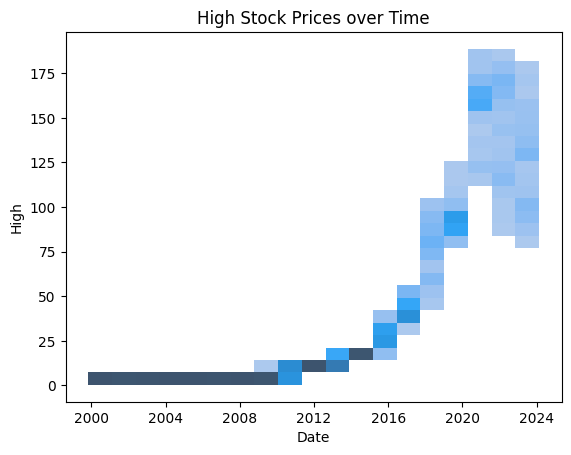

In [56]:
sns.histplot(x='date', y='high', data=df2)
plt.title('High Stock Prices over Time')
plt.xlabel('Date')
plt.ylabel('High')
plt.show()

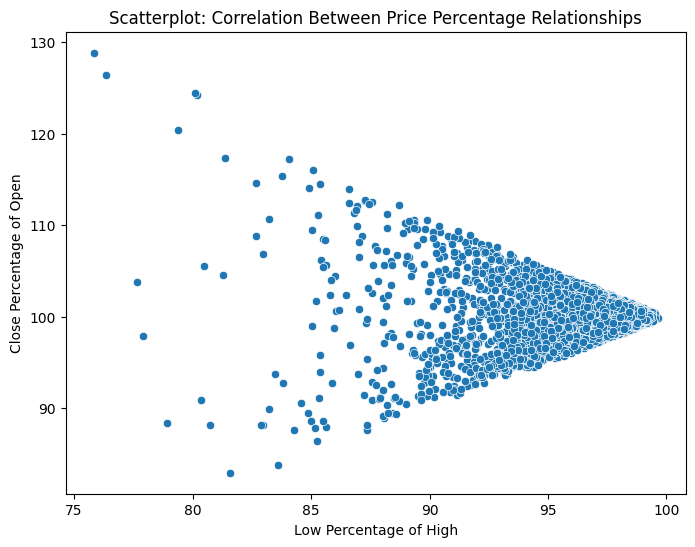

In [58]:
df2['Low_Percentage_of_High'] = (df2['low'] / df2['high']) * 100
df2['Close_Percentage_of_Open'] = (df2['close'] / df2['open']) * 100
# Scatterplot for correlation exploration
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Low_Percentage_of_High', y='Close_Percentage_of_Open', data=df2)
plt.title('Scatterplot: Correlation Between Price Percentage Relationships')
plt.xlabel('Low Percentage of High')
plt.ylabel('Close Percentage of Open')
plt.show()

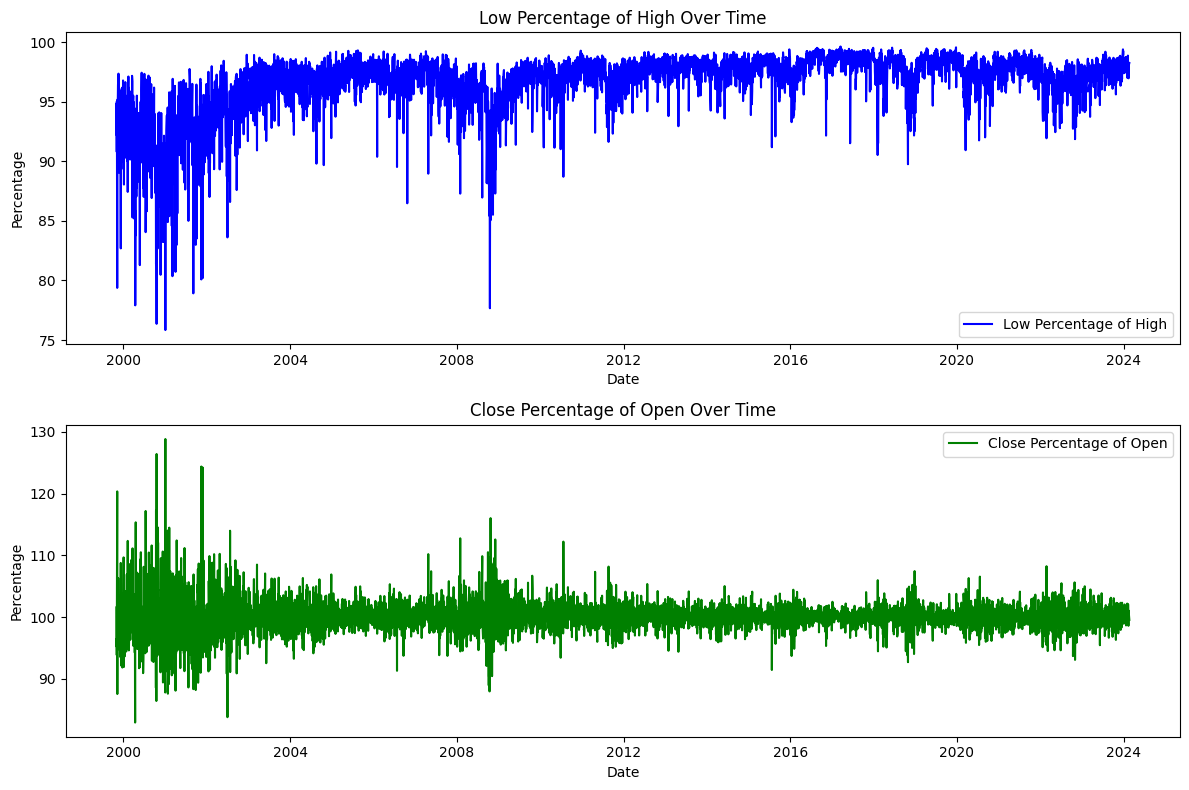

In [60]:
# Visualization
plt.figure(figsize=(12, 8))
# Line graph for Low Percentage of High
plt.subplot(2, 1, 1)
plt.plot(df2.index, df2['Low_Percentage_of_High'], label='Low Percentage of High', color='blue')
plt.title('Low Percentage of High Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.legend()
# Line graph for Close Percentage of Open
plt.subplot(2, 1, 2)
plt.plot(df2.index, df2['Close_Percentage_of_Open'], label='Close Percentage of Open', color='green')
plt.title('Close Percentage of Open Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.legend()
# Adjust layout
plt.tight_layout()
# Show the plots
plt.show()

Average Percentage Difference: 100.05%


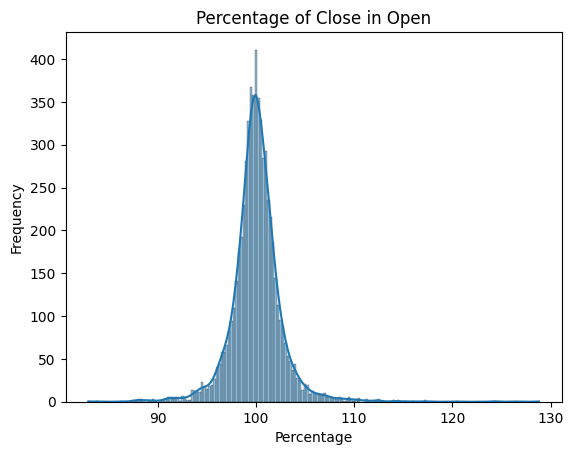

In [61]:
# Calculate the average percentage difference
df2['percentage_close_in_open'] = (df2['close'] / df2['open']) * 100
# Calculate the average percentage difference
average_percentage_difference = df2['percentage_close_in_open'].mean()
# Print the average percentage difference
print(f'Average Percentage Difference: {average_percentage_difference:.2f}%')
#histograph for percentage distribution
sns.histplot(df2['percentage_close_in_open'], kde=True)
plt.title('Percentage of Close in Open')
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.show()

Standard Deviation of Percentage Difference: 2.60%


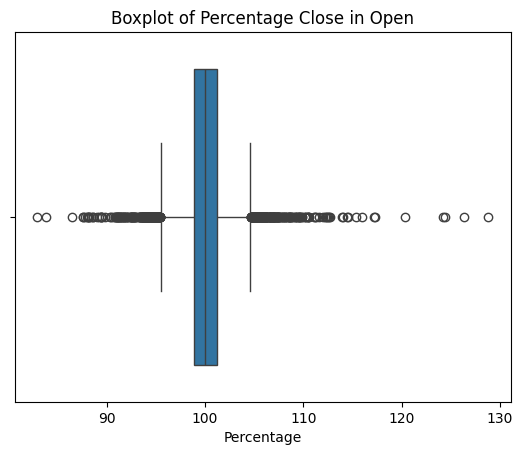

In [62]:
# Calculate the standard deviation of percentage difference
std_dev_percentage_difference = df2['percentage_close_in_open'].std()
# Print the standard deviation of percentage difference
print(f'Standard Deviation of Percentage Difference: {std_dev_percentage_difference:.2f}%')
sns.boxplot(x=df2['percentage_close_in_open'])
plt.title('Boxplot of Percentage Close in Open')
plt.xlabel('Percentage')
plt.show()